# Importing required libraries

In [1]:
from dateutil.parser import parse 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import scipy.stats as sp

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

#plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Importing the dataset

In [2]:
# Fetching the data
data = pd.read_csv('Imports Crude Oil.csv')
data.head()

,Unnamed: 0,"Imports of all grades of crude oil from World to Total U.S. (US), Monthly (thousand barrels)"
0,2009 01,317275
1,2009 02,262339
2,2009 03,303897
3,2009 04,285934
4,2009 05,281147


# EDA and Preprocessing the Data

In [3]:
# Changing column names
data.columns = ['Date','Price']
#print(data.tail())
data.drop(data.tail(1).index,inplace = True)
# Data is from Jan 1990 to Dec 2022
# We have 33 years data

In [4]:
print(data.tail())

         Date   Price
139  2020 08   168406
140  2020 09   161926
141  2020 10   164494
142  2020 11   168655
143  2020 12   178597


In [5]:
# Checking data types of the columns as date format is different
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    144 non-null    object
 1   Price   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


In [40]:
data.describe()

,Price,year
count,144.000000,144.000000
mean,241315.215278,2014.500000
std,34164.503866,3.464102
min,161926.000000,2009.000000
25%,221226.750000,2011.750000
50%,239865.500000,2014.500000
75%,265666.750000,2017.250000
max,318991.000000,2020.000000


In [6]:
# Correcting date format
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)
data.head()

,Date,Price
0,2009-01-01,317275
1,2009-02-01,262339
2,2009-03-01,303897
3,2009-04-01,285934
4,2009-05-01,281147


'The high rates of unemployment caused by the Great Recession have remained persistently high in recent periods. \nAt the same time, oil prices rose significantly mainly as a result of the increase in demand from China and India.\n\nThe 2008 financial crisis and Great Recession induced a bear market in oil and gas, sending the price of a barrel \nof crude oil from nearly $150 to $35 in just a few months. \nThe recession led to a general drop in asset prices around the world as credit contracted and earnings projections fell.'

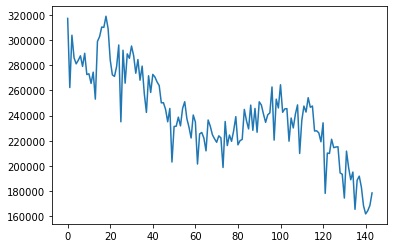

In [7]:
plt.plot(data['Price'])
#plt.plot(data['Price'].ewm(span=15).mean())

'''The high rates of unemployment caused by the Great Recession have remained persistently high in recent periods. 
At the same time, oil prices rose significantly mainly as a result of the increase in demand from China and India.

The 2008 financial crisis and Great Recession induced a bear market in oil and gas, sending the price of a barrel 
of crude oil from nearly $150 to $35 in just a few months. 
The recession led to a general drop in asset prices around the world as credit contracted and earnings projections fell.'''

In [8]:
# Smoothning the Data
#data['Price'] = data['Price'].ewm(span=15).mean()

In [9]:
# Setting the Date column as the index
data = data.set_index('Date')
data

,Price
Date,
2009-01-01,317275
2009-02-01,262339
2009-03-01,303897
2009-04-01,285934
2009-05-01,281147
...,...
2020-08-01,168406
2020-09-01,161926
2020-10-01,164494


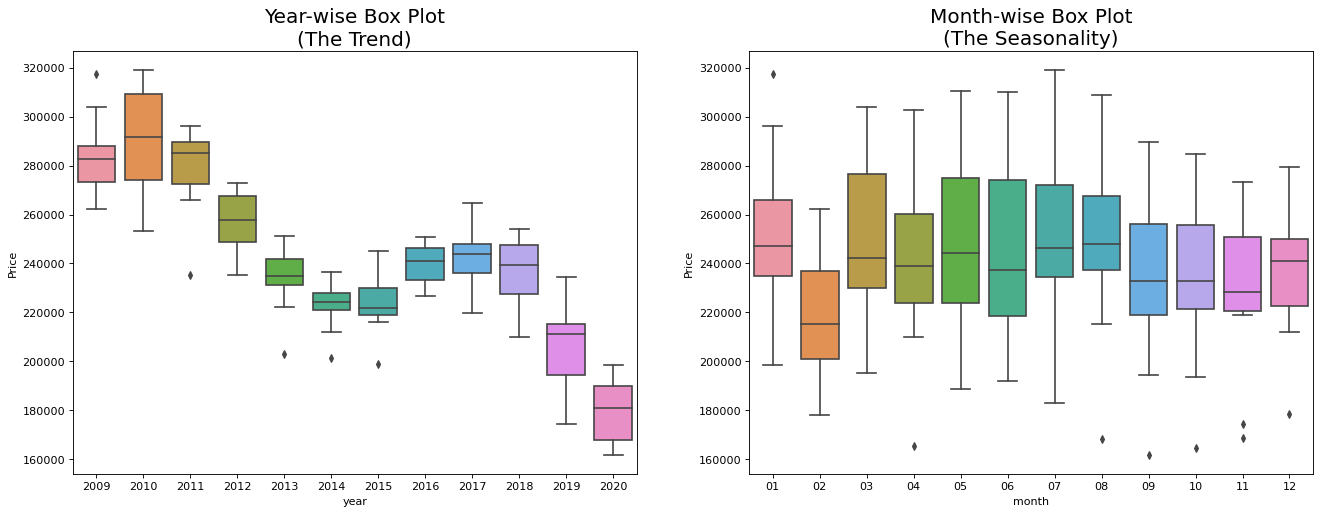

In [10]:
# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution
# Prepare data
data = data.reset_index()
df = data
df['year'] = [d.year for d in data.Date]
df['month'] = [d.strftime('%m') for d in data.Date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=df, ax=axes[0])
sns.boxplot(x='month', y='Price', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# There seems to be a trend the data but no seasonality

# Splitting the Data into train and test

In [11]:
train = data.iloc[:int(0.7*len(data))-1,:]
test = data.iloc[int(0.7*len(data))-1:,:]

In [12]:
train

,Date,Price,year,month
0,2009-01-01,317275,2009,01
1,2009-02-01,262339,2009,02
2,2009-03-01,303897,2009,03
3,2009-04-01,285934,2009,04
4,2009-05-01,281147,2009,05
...,...,...,...,...
94,2016-11-01,240691,2016,11
95,2016-12-01,242213,2016,12
96,2017-01-01,262811,2017,01
97,2017-02-01,220558,2017,02


In [13]:
test

,Date,Price,year,month
99,2017-04-01,246132,2017,04
100,2017-05-01,264554,2017,05
101,2017-06-01,242677,2017,06
102,2017-07-01,245369,2017,07
103,2017-08-01,245611,2017,08
104,2017-09-01,219708,2017,09
105,2017-10-01,238109,2017,10
106,2017-11-01,230230,2017,11
107,2017-12-01,241245,2017,12
108,2018-01-01,248552,2018,01


# Checking the trend and seasonal decompose of the train data

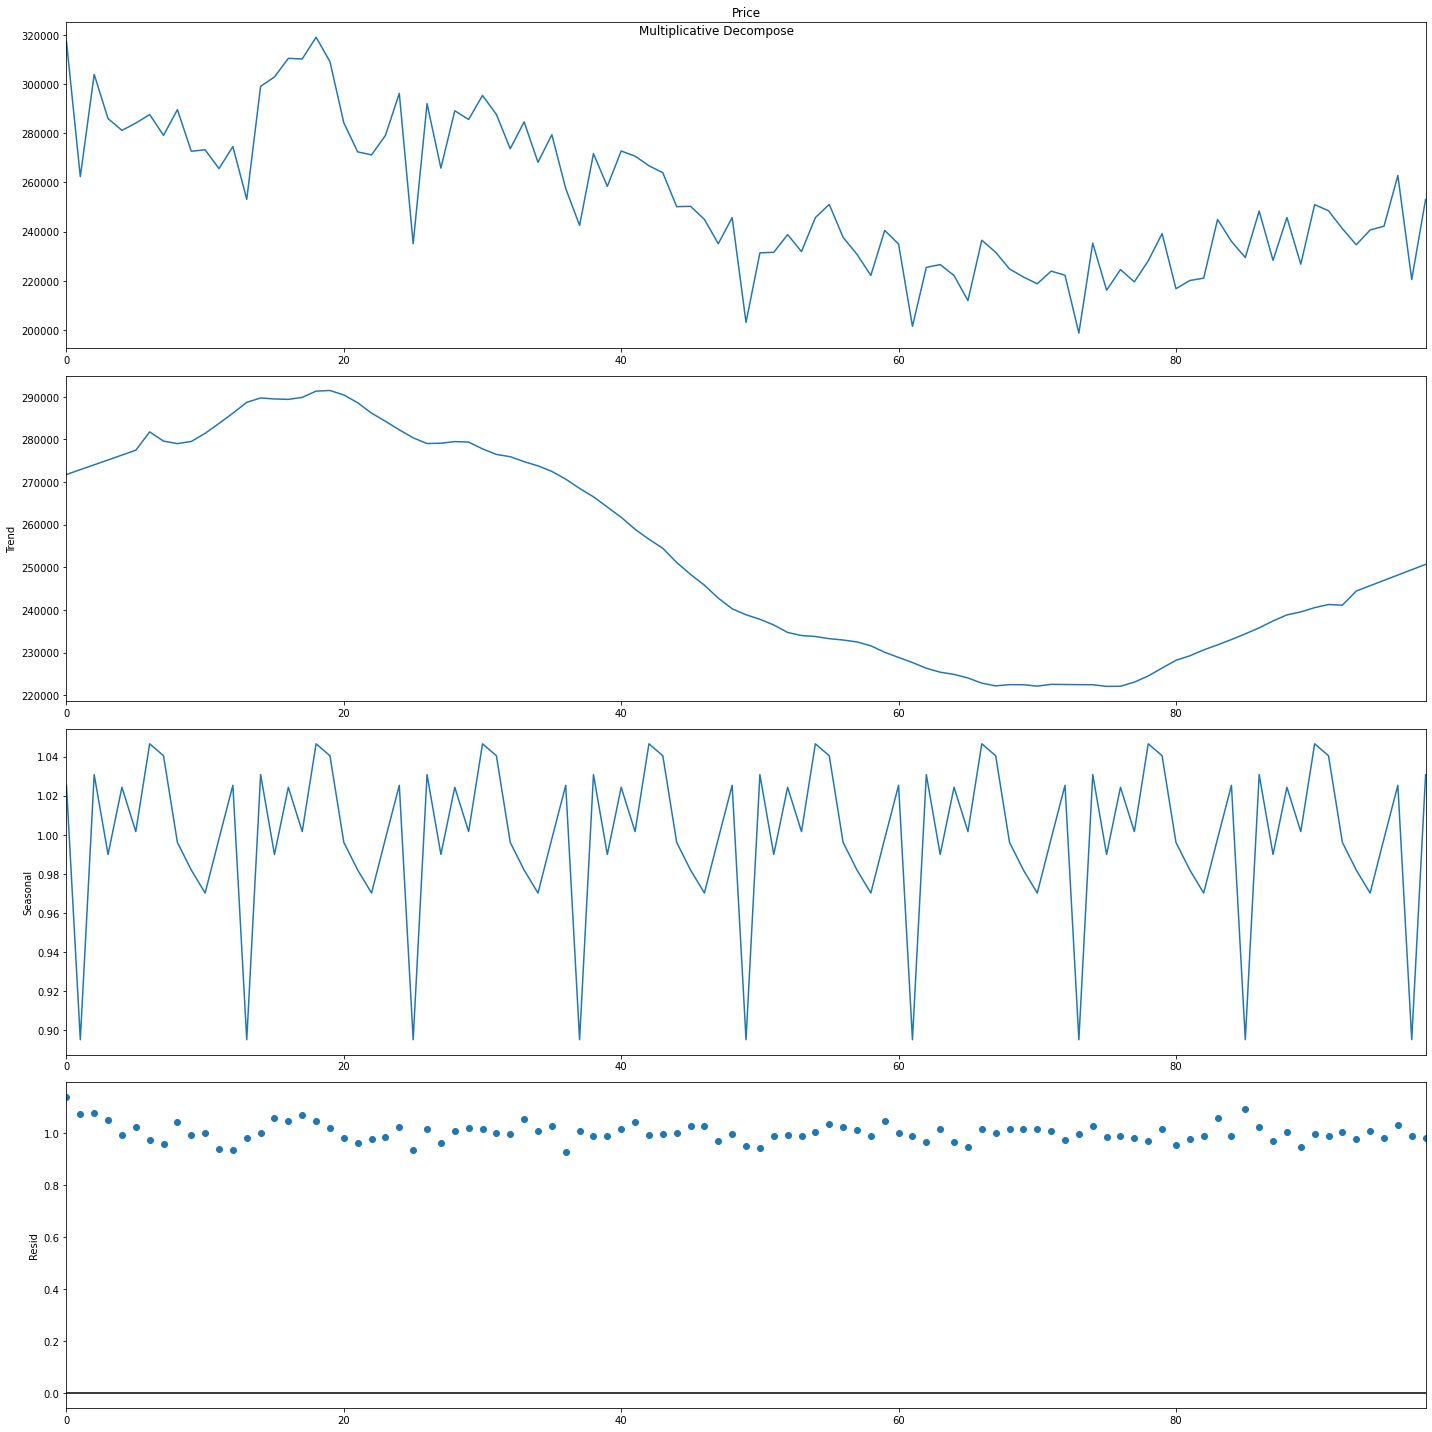

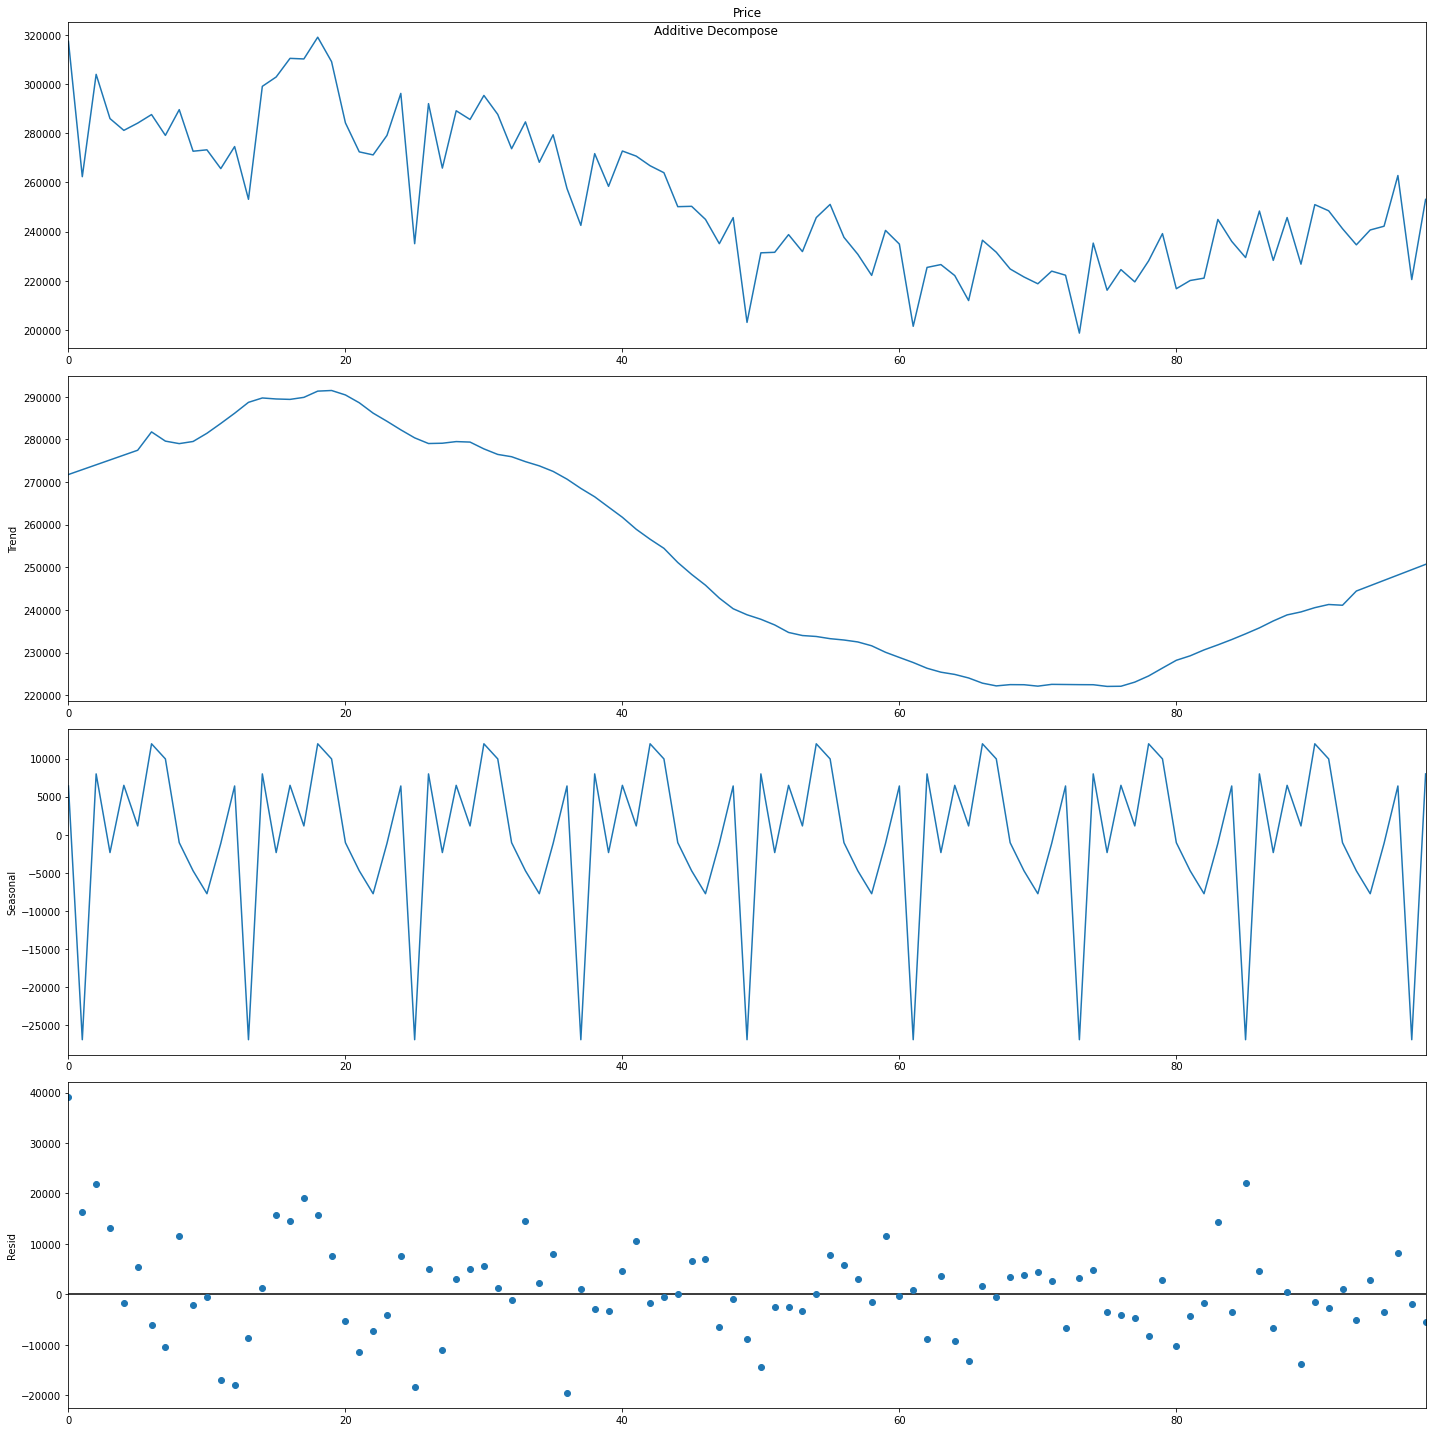

In [14]:
# Additive and multiplicative time series
# Decomposing data into additive and multiplicative components

# Multiplicative Decomposition 
result_mul = seasonal_decompose(train['Price'], period = 12, model='multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(train['Price'], period = 12, model='additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (20,20)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

# Since the residuals are better correlated in the multiplicative decompose, we can say that the data
# follows a multiplication decompose and contains both a yearly seasonal and trend element

In [15]:
# Multiplicative components
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed['product'] = df_reconstructed['seas']*df_reconstructed['trend']*df_reconstructed['resid']
df_reconstructed.head()

,seas,trend,resid,actual_values,product
0,1.025312,271765.528943,1.138638,317275.0,317275.0
1,0.895037,272904.252574,1.074018,262339.0,262339.0
2,1.030787,274042.976204,1.075818,303897.0,303897.0
3,0.989885,275181.699835,1.049691,285934.0,285934.0
4,1.024290,276320.423465,0.993340,281147.0,281147.0


# ADF and KPSS Test

In [16]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# H0: Not stationary
# Ha: Stationary
# ADF Test
result = adfuller(train.Price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value>0.05, hence accept null hypothesis, data is not stationary

# H0: Stationary
# Ha: Not Stationary
# KPSS Test - Trend Stationarity
result = kpss(train.Price.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value<0.05, hence reject null hypothesis, data is not stationary

ADF Statistic: -0.8681691977265296
p-value: 0.7982739870916742
Critial Values:
   1%, -3.5087828609430614
Critial Values:
   5%, -2.895783561573195
Critial Values:
   10%, -2.5850381719848565

KPSS Statistic: 0.698388
p-value: 0.013692
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


# De-trending the data

**Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.**  
  
- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.  
- Subtract the trend component obtained from time series decomposition we saw earlier.  
  
- Subtract the mean  
  
- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

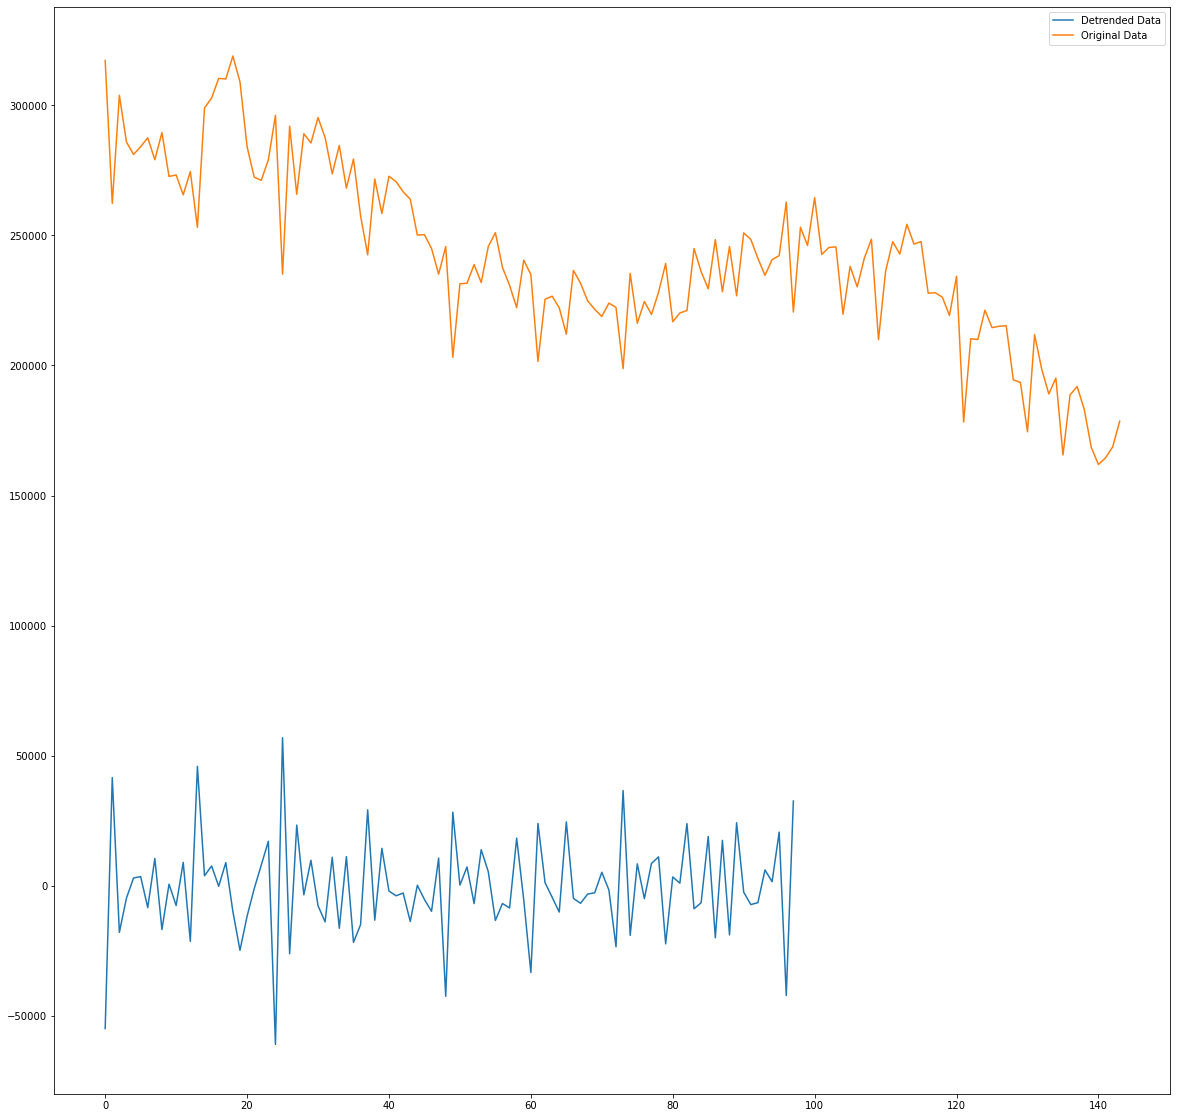

In [17]:
# Given data follows a stochastic trend that is increase and decrease in values does not follow a consistent pattern

# Detrending using difference method
#create a differenced series
def difference(dataset,interval=1):
    diff=list()
    for i in range(interval,len(dataset)):
        value=dataset[i]-dataset[i-interval]
        diff.append(value)
    return (diff)

df_detrend=difference(train['Price'])

plt.plot(df_detrend,label = 'Detrended Data')
plt.plot(data.Price.values,label='Original Data')
#plt.plot(pd.DataFrame(df_detrend.values).ewm(span=15).mean(),label='EWM')
plt.legend()

In [18]:
# Testing for stationarity on detrended data
from statsmodels.tsa.stattools import adfuller, kpss

# H0: Not stationary
# Ha: Stationary
# ADF Test
result = adfuller(df_detrend, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value<0.05, hence accept null hypothesis, data is stationary

# H0: Stationary
# Ha: Not Stationary
# KPSS Test - Trend Stationarity
result = kpss(df_detrend, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value>0.05, hence reject null hypothesis, data is stationary

ADF Statistic: -2.6778067366629923
p-value: 0.07795803519633855
Critial Values:
   1%, -3.5097356063504983
Critial Values:
   5%, -2.8961947486260944
Critial Values:
   10%, -2.5852576124567475

KPSS Statistic: 0.247254
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


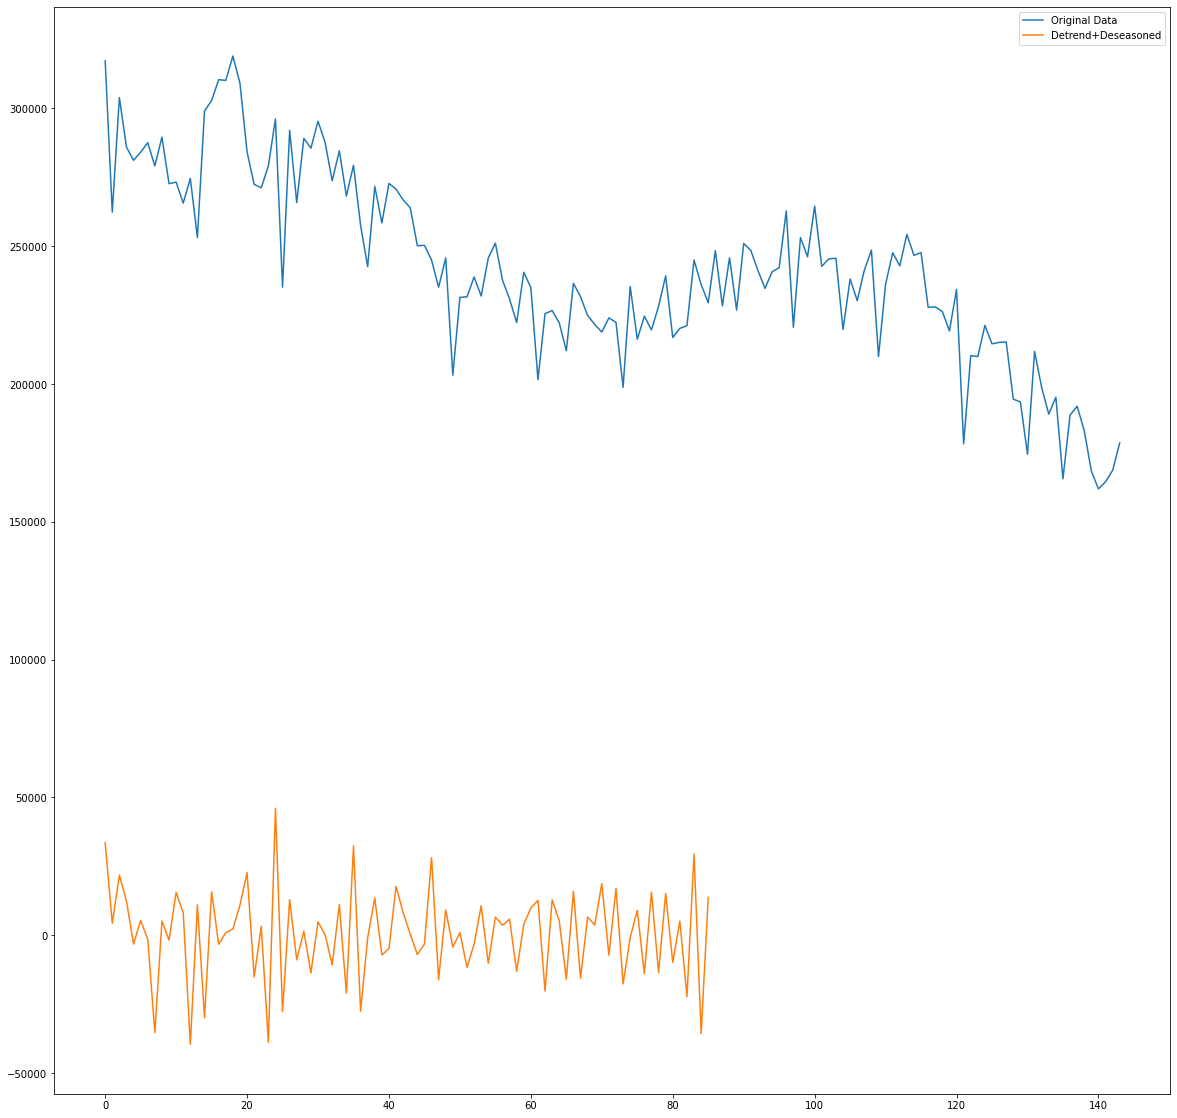

In [19]:
# De-seasonalize the data

df_final=difference(df_detrend,12)
df_deseasoned=difference(train['Price'],12)

plt.plot(data.Price.values,label='Original Data')
#plt.plot(df_deseasoned, label = 'Deseasoned')
plt.plot(df_final, label = 'Detrend+Deseasoned')
plt.legend()

In [20]:
# Testing for stationarity on detrended data
from statsmodels.tsa.stattools import adfuller, kpss

# H0: Not stationary
# Ha: Stationary
# ADF Test
result = adfuller(df_final, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value<0.05, hence accept null hypothesis, data is stationary

# H0: Stationary
# Ha: Not Stationary
# KPSS Test - Trend Stationarity
result = kpss(df_final, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
# p value>0.05, hence reject null hypothesis, data is stationary

ADF Statistic: -4.229195276678718
p-value: 0.0005878032554288853
Critial Values:
   1%, -3.5232835753964475
Critial Values:
   5%, -2.902030597326081
Critial Values:
   10%, -2.5883710883843123

KPSS Statistic: 0.096235
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# ACF and PACF Plots

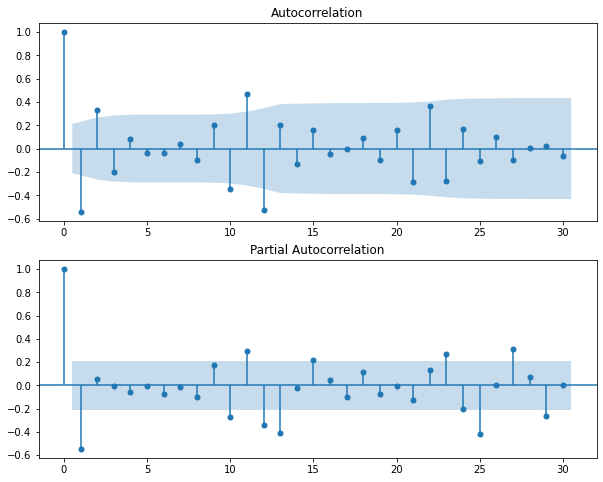

In [21]:
fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df_final,lags=30,ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df_final,lags=30,ax=ax2)

# ACF is gradual and PACF is sudden. Hence it is AR(p) model with p = 1 from PACF plot

# Auto ARIMA

In [22]:
import pmdarima as pm

In [23]:
myfit = pm.auto_arima(train['Price'], m=12,seasonal=True,trace=True, start_p = 0, start_q = 0, d=1,D=1,
                      error_action='ignore', # don't want to know if an order does not work
                      suppress_warnings=True, # don't want convergence warnings
                      stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1910.706, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1917.688, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1897.601, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1897.716, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1902.175, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1898.835, Time=0.46 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1890.671, Time=0.43 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1897.938, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1892.639, Time=1.32 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1892.632, Time=1.48 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1899.761, Time=0.50 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=1892.760, Time=0.61 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1893.178, Time=1.00 sec
 ARIMA(0,1,1)(1,1,1)[12]

# ARIMA

In [24]:
# Parameters generated from acf,pacf plots
#model=sm.tsa.arima.ARIMA(train['Price'],order=(1,1,0),seasonal_order = (0,1,0,12))
# Parameters generated from auto ARIMA 
model=sm.tsa.arima.ARIMA(train['Price'],order=(1,1,0),seasonal_order = (1,1,1,12))

model_res=model.fit()

print(model_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                   99
Model:             ARIMA(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -941.336
Date:                            Wed, 04 May 2022   AIC                           1890.671
Time:                                    12:36:49   BIC                           1900.489
Sample:                                         0   HQIC                          1894.622
                                             - 99                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1567      0.040     -3.936      0.000      -0.235      -0.079
ar.S.L12      -0.8802      0.116   

In [25]:
tspredict= model_res.predict(20)

tsforecast=model_res.forecast(45)

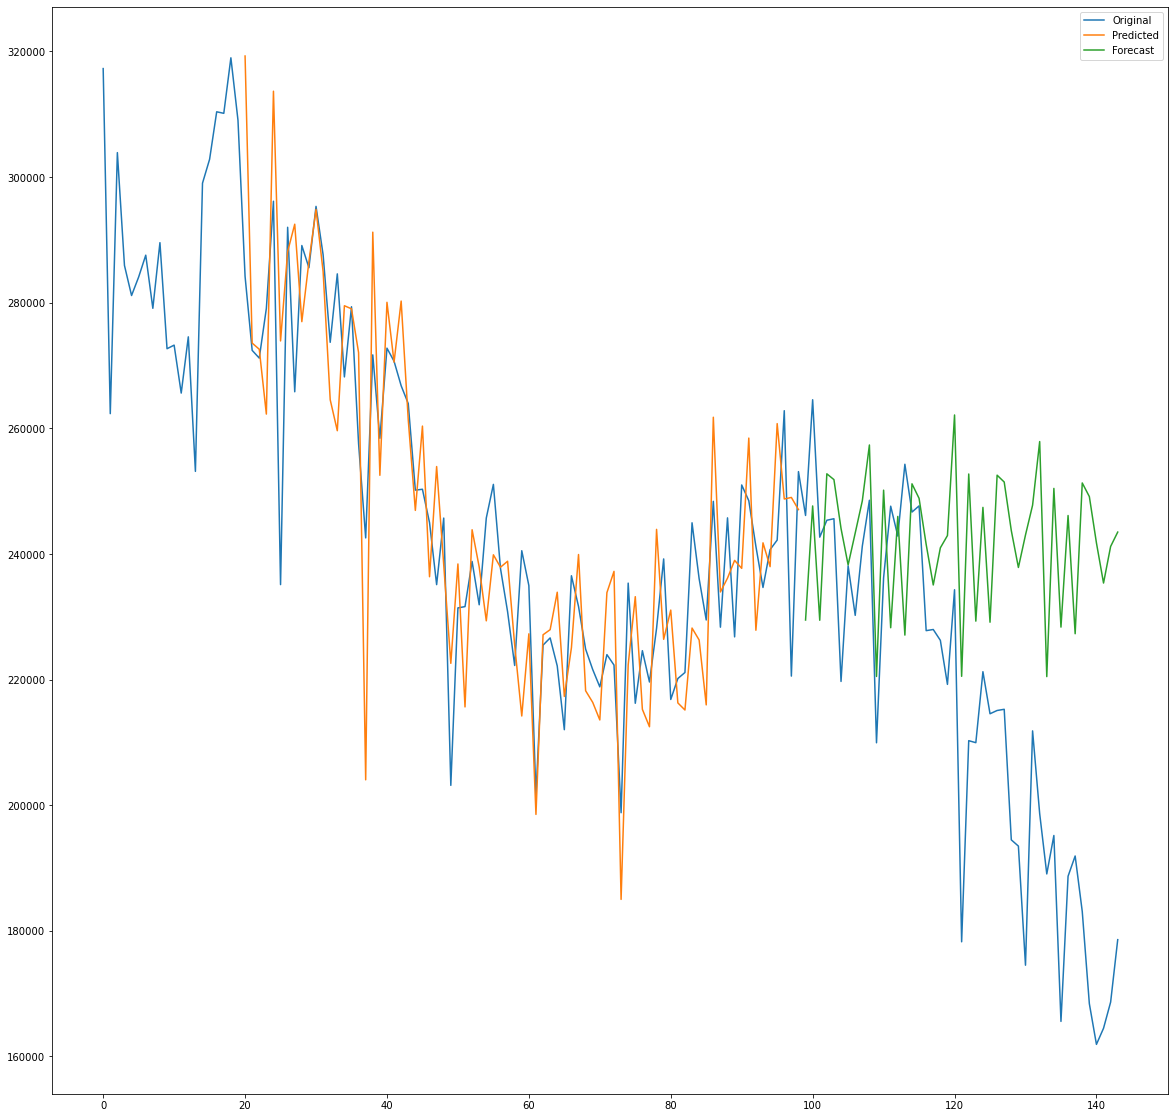

In [26]:
plt.plot(data['Price'], label='Original')
plt.plot(tspredict, label='Predicted')
plt.plot(tsforecast, label='Forecast')
plt.legend()

In [27]:
#Rmse Value For model generated through M1 Process
rmse = mean_squared_error(test['Price'], model_res.forecast(45), squared=False)
rmse

39719.88238772314

In [28]:
#Rmse Value For model generated through M2 Process
rmse = mean_squared_error(test['Price'], model_res.forecast(45), squared=False)
rmse

39719.88238772314

# Holt

In [29]:
from statsmodels.tsa.holtwinters import Holt

In [30]:
model = Holt(train['Price'], exponential=True)

result = model.fit()

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [31]:
result.params

{'smoothing_level': 0.5471428571428572,
 'smoothing_trend': 0.5471428571428572,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 317275.0,
 'initial_trend': 0.8268505239933811,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

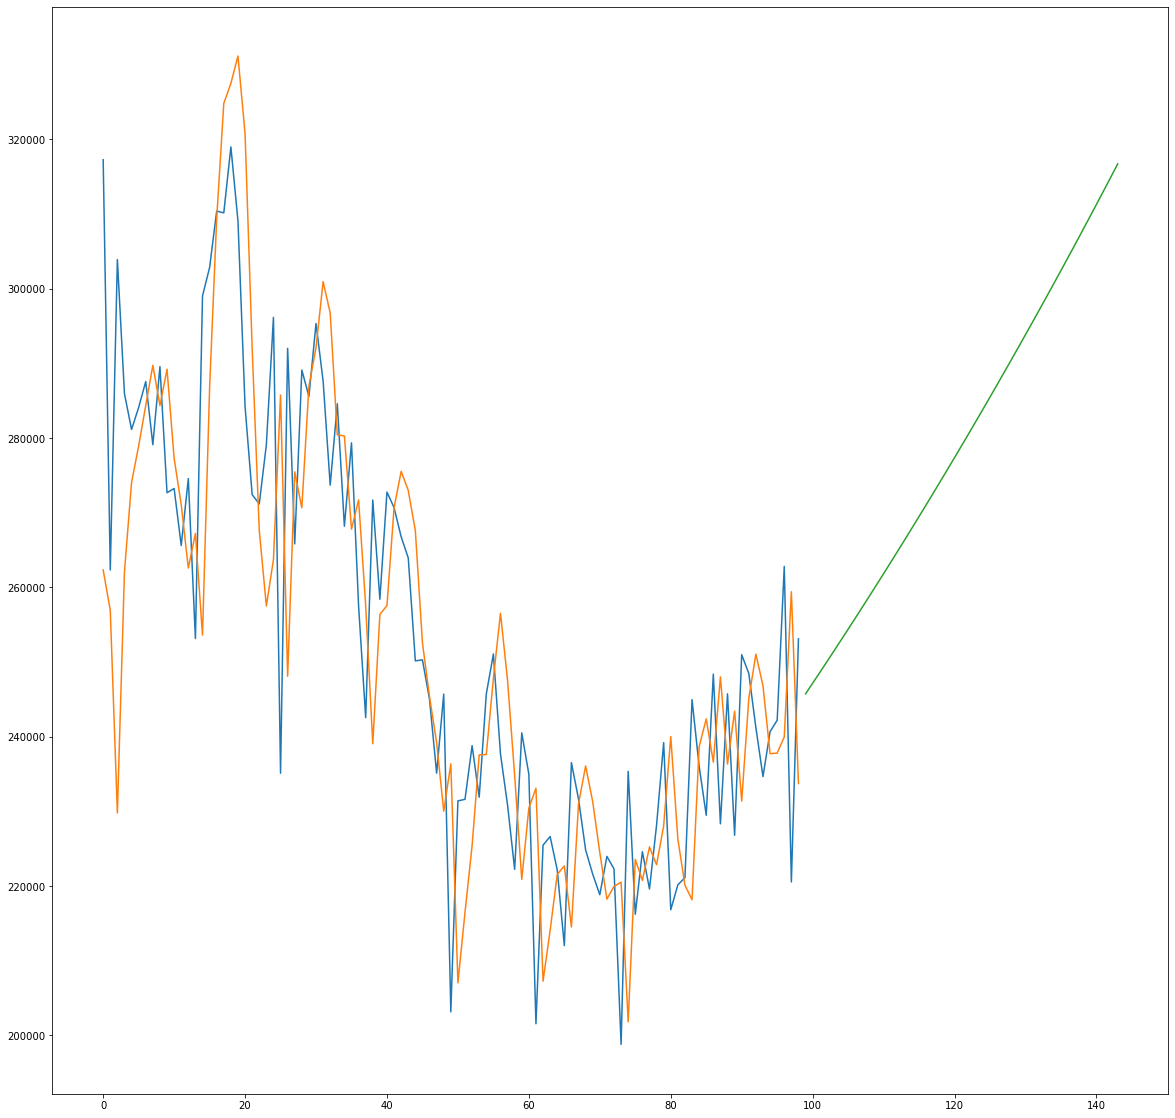

In [32]:
plt.plot(train['Price'])
plt.plot(result.fittedvalues)
plt.plot(result.forecast(45))

In [33]:
rmse = mean_squared_error(test['Price'], result.forecast(45), squared=False)
rmse

81288.73700429562

# Exponential Smoothing

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [35]:
model = ExponentialSmoothing(train['Price'], trend='multiplicative', seasonal='additive', seasonal_periods=12)

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [36]:
result3 = model.fit()
result3.params

C:\Users\Amisha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.5707142857142857,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.27112781954887216,
 'damping_trend': nan,
 'initial_level': 260823.55555555556,
 'initial_trend': 1.0020008990882934,
 'initial_seasons': array([56451.44444444,  1515.44444444, 43073.44444444, 25110.44444444,
        20323.44444444, 23269.44444444, 26745.44444444, 18287.44444444,
        28737.44444444, 11854.44444444, 12424.44444444,  4791.44444444]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [37]:
result3.summary()

Dep. Variable:,Price,No. Observations:,99
Model:,ExponentialSmoothing,SSE,18084478684.849
Optimized:,True,AIC,1915.297
Trend:,Multiplicative,BIC,1956.819
Seasonal:,Additive,AICC,1923.847
Seasonal Periods:,12,Date:,"Wed, 04 May 2022"
Box-Cox:,False,Time:,12:36:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5707143,alpha,True
smoothing_trend,0.0001,beta,True


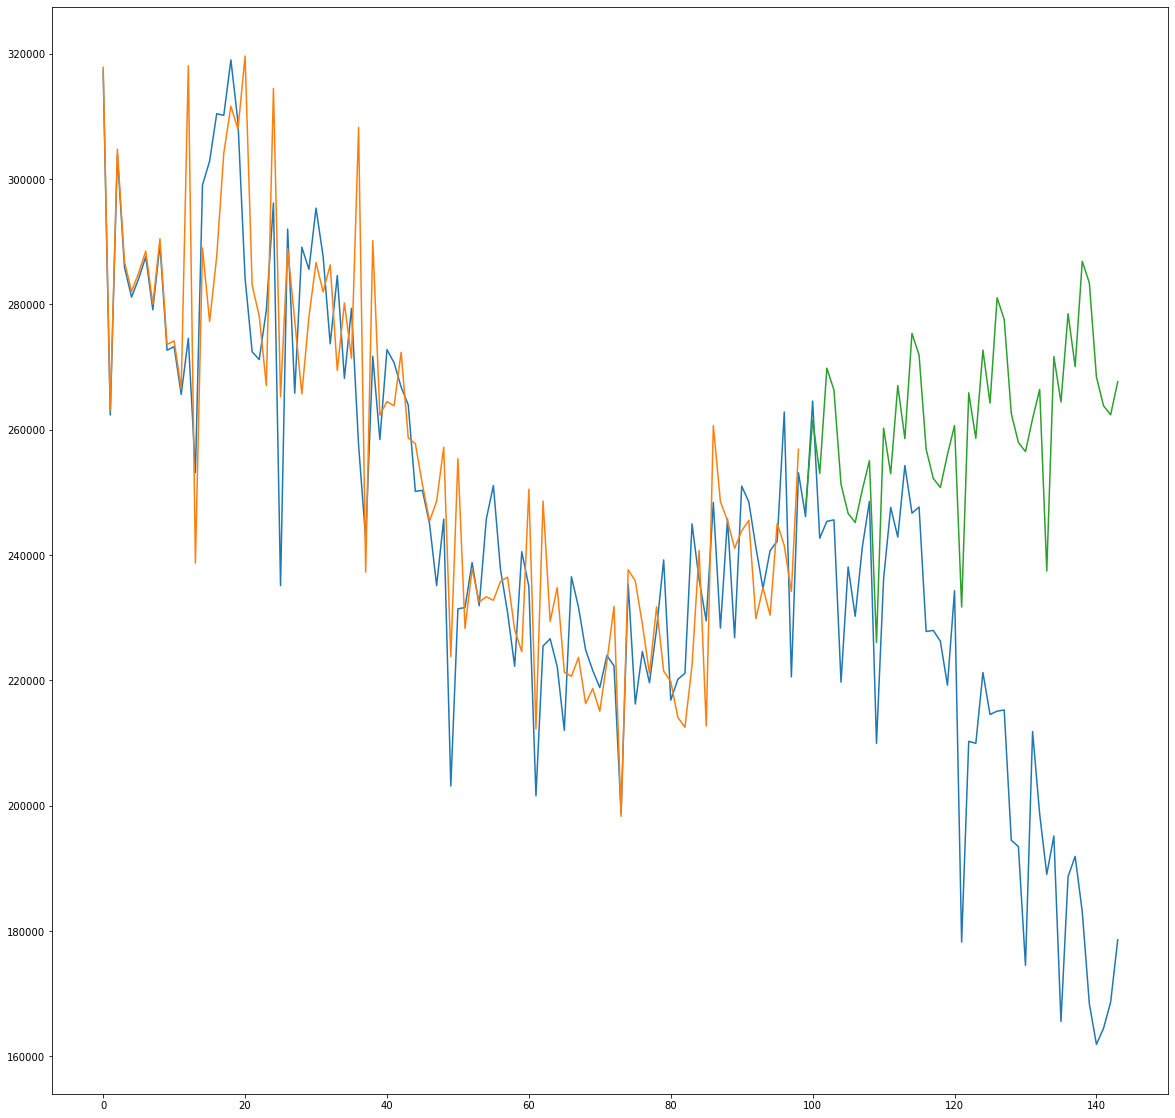

In [38]:
plt.plot(data['Price'])
plt.plot(result3.fittedvalues)
plt.plot(result3.forecast(45))

In [39]:
rmse = mean_squared_error(test['Price'], result3.forecast(45), squared=False)
rmse

57311.83392979364